In [7]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from random import randrange, choices
from scipy import signal
from sklearn.preprocessing import power_transform, StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (10, 7)

pd.options.display.max_rows = 300

In [8]:
_df = None
def fetch(df):
    global _df
    _df = df
    return df

def corr_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]

In [4]:
df = pd.read_feather('train.ft')
df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0,2,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0,6,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0,7,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0,8,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [6]:
df.isnull().sum().sum().T

0

array([<AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>], dtype=object)

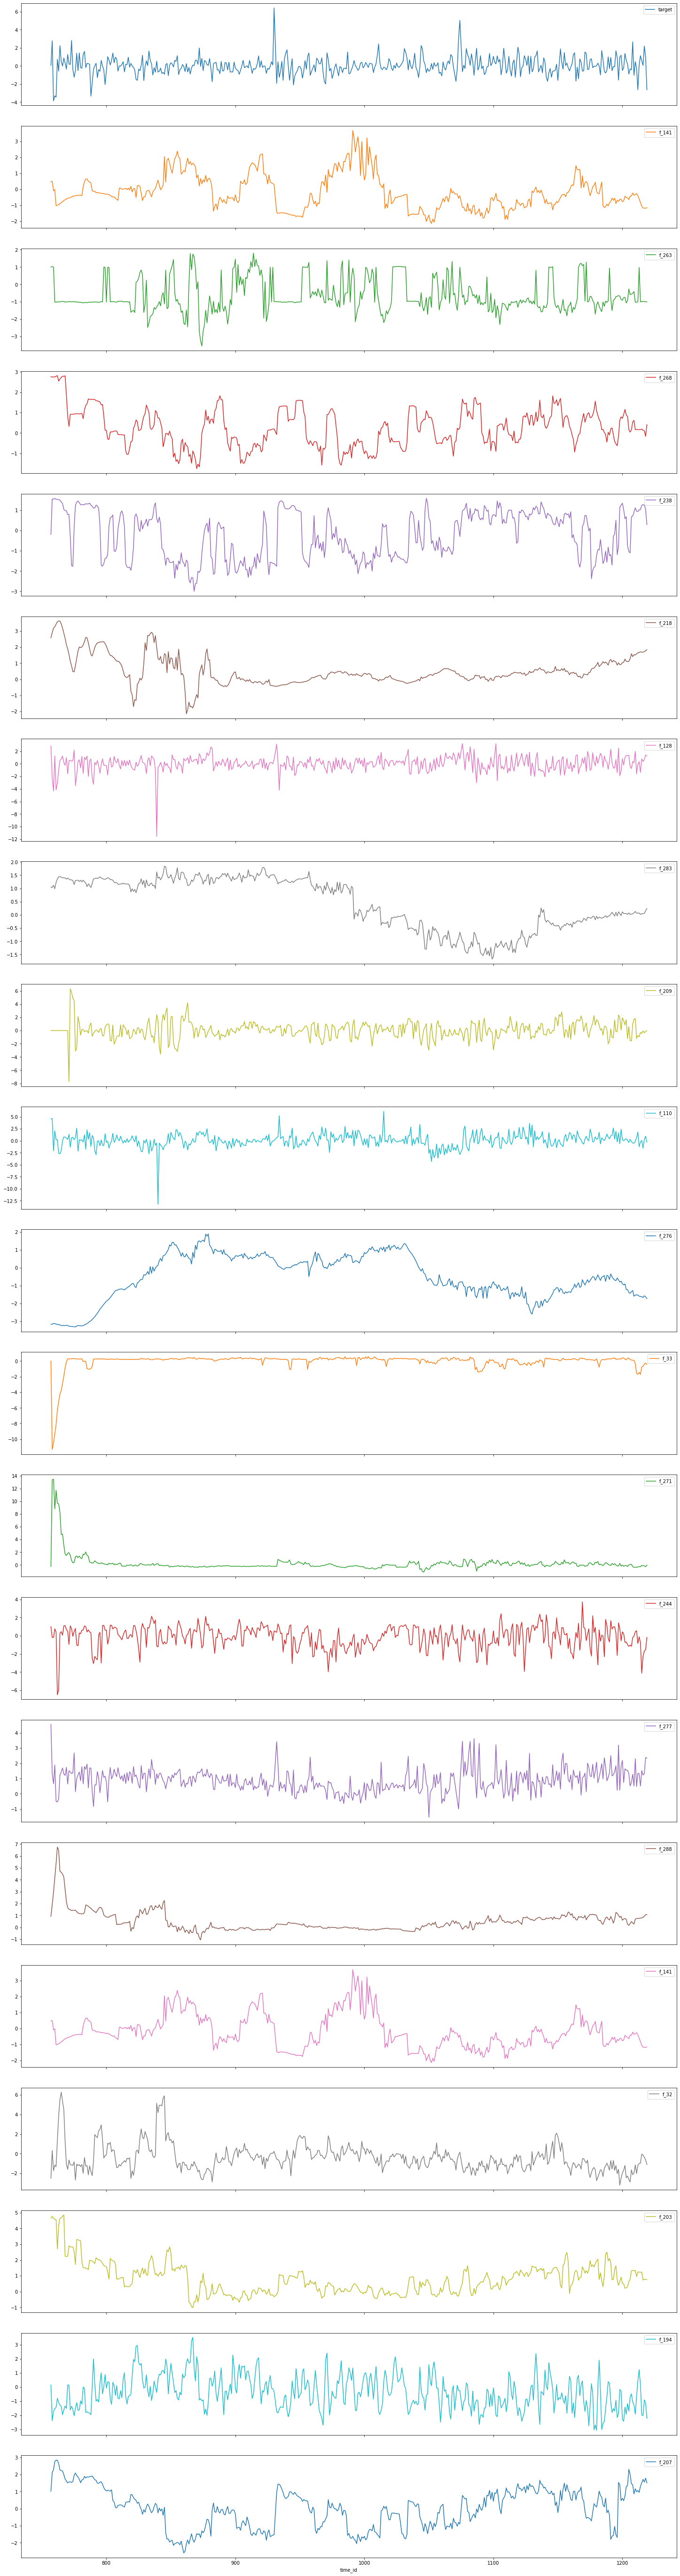

In [143]:
(
    df
    [df.investment_id == 0]
    .plot(x='time_id', y=['target'] + [f'f_{i}' for i in choices(range(300), k=20)], figsize=(25, 100), subplots=True)
)

array([<AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>], dtype=object)

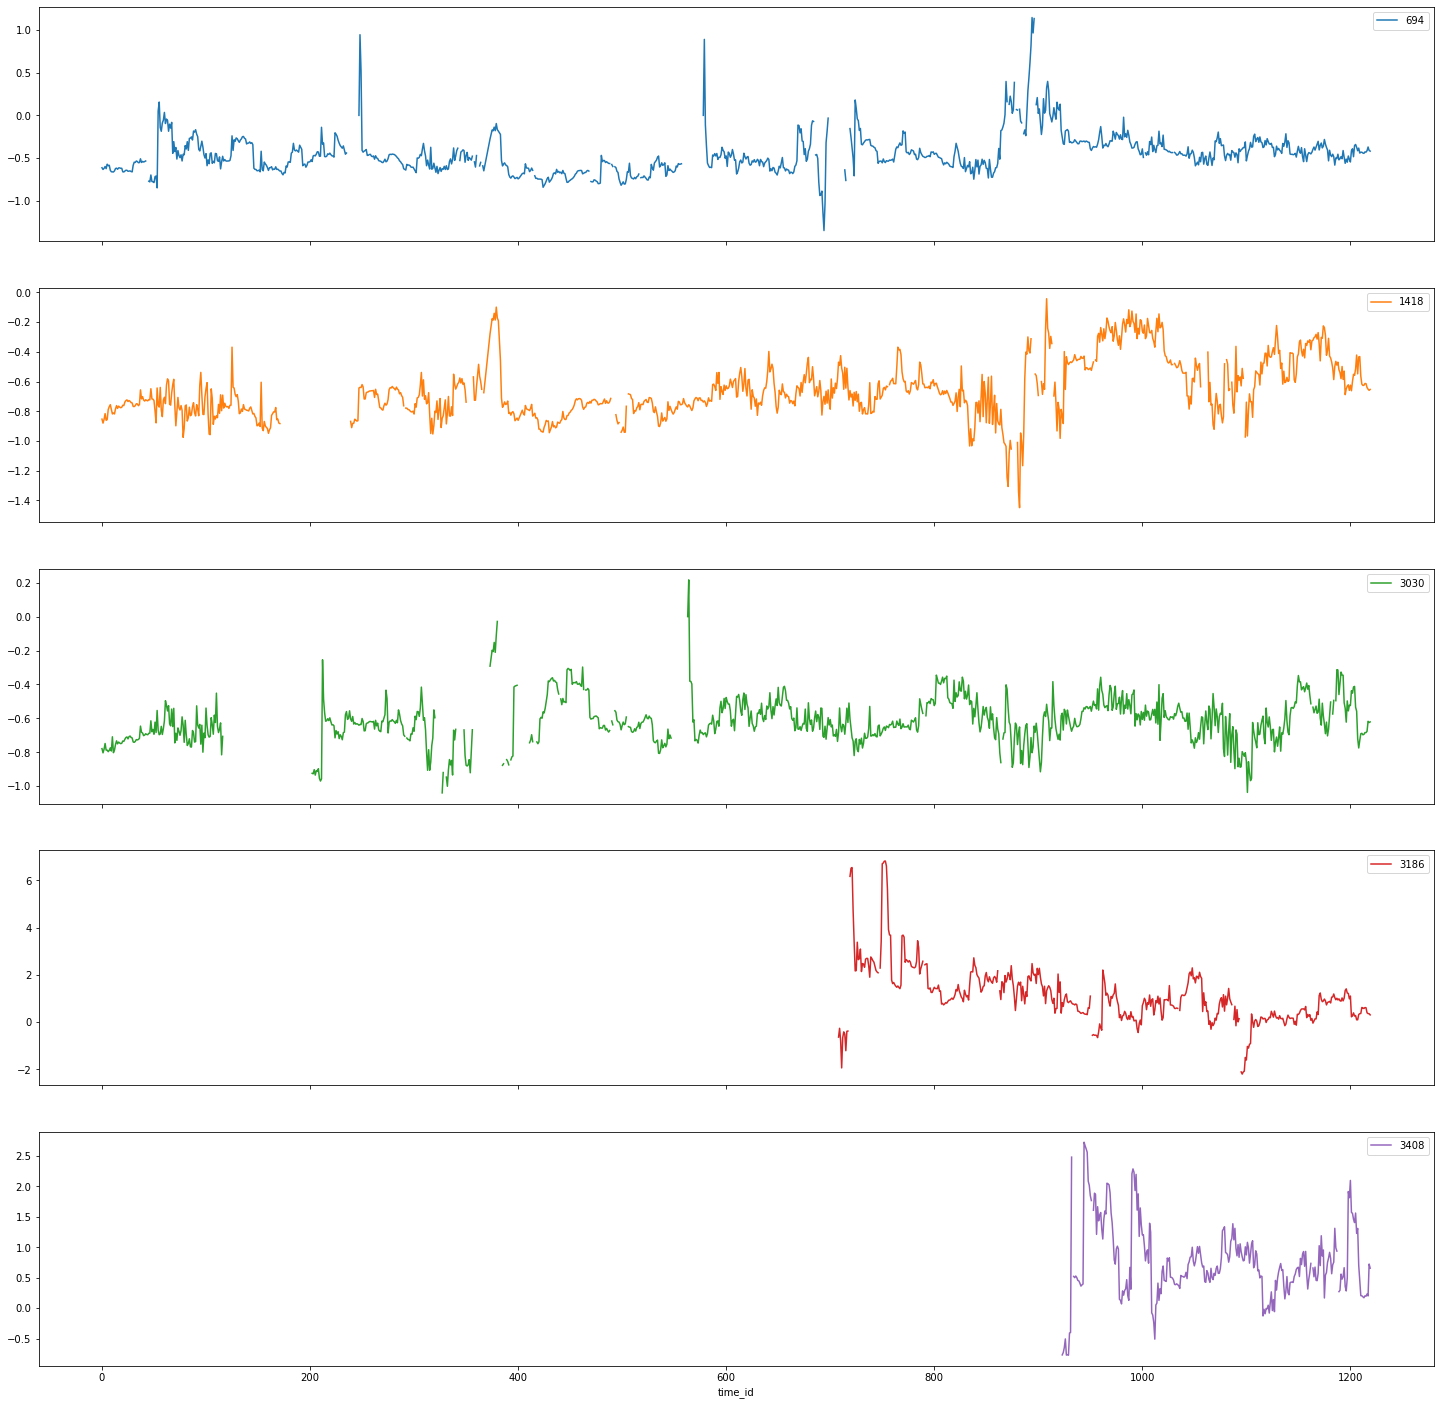

In [212]:
feature = 'f_299'

(
    df
    [df.investment_id.isin(choices(range(4000), k=5))]
    .pipe(fetch)
    .assign(f=_df[feature].astype('float64'))
    [['time_id', 'investment_id', 'f']]
    .pivot(index='time_id', columns='investment_id', values='f')
    .plot(figsize=(25, 25), subplots=True)
)

array([<AxesSubplot:xlabel='time_id'>, <AxesSubplot:xlabel='time_id'>,
       <AxesSubplot:xlabel='time_id'>], dtype=object)

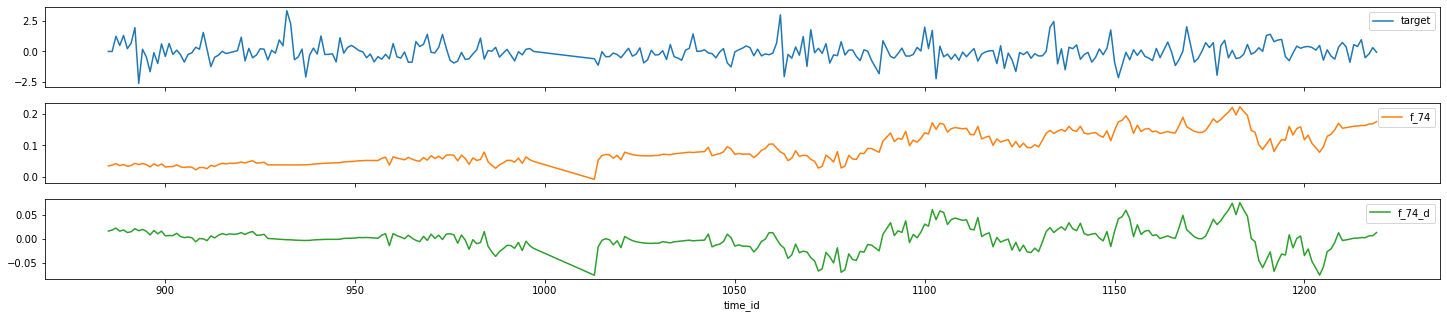

In [181]:
(
    df
    #[['f_0', 'f_37', 'f_41', 'f_124', 'f_191', 'f_246']]
    #.fillna(0)
    #.describe()
    [df.investment_id == 4]
    .assign(f_74_d=signal.detrend(df[df.investment_id == 4]['f_74']))
    .plot(x='time_id', y=['target'] + ['f_74', 'f_74_d'], figsize=(25, 5), subplots=True)
    #['f_191']
    #[['f_37', 'f_41', 'f_124', 'f_191', 'f_246']]
    #.hist(figsize=(20, 10), bins=20)
)

# Investiments Clusters

In [41]:
investiments = df.investment_id.sort_values().unique()

In [7]:
def correlations(idx):
    corr = (
        df
        [df.investment_id == idx]
        [['target'] + [f'f_{i}' for i in range(300)]]
        .corr()
        ['target']
    )
    corr = corr.drop('target')
    corr.name = idx
    return corr

In [8]:
feats_corr = []
for i in investiments:
    corr = correlations(i)
    feats_corr.append(corr)

In [9]:
feats_corr = pd.concat(feats_corr, axis=1).T

In [152]:
feats_corr

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,likehood,likelyhood
0,-0.069765,-0.099172,-0.010849,-0.036268,-0.046009,0.095811,0.099453,-0.004115,0.031178,0.008509,...,-0.078060,0.006785,0.012722,-0.035788,0.018331,-0.088206,-0.006773,-0.007012,514.867863,514.783799
1,-0.030215,-0.034839,0.014662,-0.059384,-0.020324,0.012255,-0.006533,-0.024957,0.065991,0.000639,...,0.036787,0.041042,-0.025031,-0.036486,0.034377,-0.009367,0.003529,0.014512,655.057887,655.082203
2,0.000650,-0.063263,0.097640,-0.132185,-0.133467,0.038784,0.011597,-0.008417,0.087476,-0.034802,...,-0.006573,-0.040120,0.019690,-0.060640,0.034092,-0.024974,0.006006,-0.030046,661.665284,661.776599
3,0.018353,-0.021022,0.034517,-0.032313,-0.044167,0.044632,-0.036604,-0.013757,0.042337,-0.040860,...,-0.007984,0.026575,0.018108,-0.069259,0.037922,-0.020666,-0.009592,-0.043689,653.831259,653.882992
4,0.109611,-0.041563,-0.006084,-0.040697,-0.022055,0.010342,0.038813,0.013270,0.035407,0.057979,...,-0.036466,-0.012979,0.055398,-0.040623,0.060490,0.000320,-0.041658,-0.055598,478.444739,478.382681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,-0.001081,-0.070728,0.070365,-0.043750,-0.020930,0.067100,-0.027778,0.030599,0.092632,-0.046444,...,0.001744,-0.037274,-0.045148,0.007992,0.017489,-0.102804,-0.045026,0.017844,659.137587,659.194625
3769,0.013137,0.104987,0.036200,0.054457,0.003799,-0.017109,0.027521,0.031878,0.010963,0.006017,...,-0.007717,-0.044425,-0.011012,-0.109034,-0.009059,-0.043158,-0.000691,0.058067,655.342315,655.387903
3770,-0.000208,-0.021423,0.018807,-0.096820,-0.031313,0.012279,0.007380,-0.025650,0.021545,-0.033419,...,-0.010104,-0.042741,0.023927,-0.009692,0.008355,-0.056604,-0.052138,0.001291,659.815857,659.939140
3772,0.000587,-0.040241,0.086473,-0.082062,-0.000897,0.039201,-0.031229,0.001759,0.051805,-0.055802,...,-0.025887,-0.019295,-0.073618,-0.128087,-0.017813,-0.135515,0.001548,-0.054430,660.421691,660.413477


In [50]:
(
    feats_corr.describe().T
    .pipe(fetch)
    [_df['count'] < _df['count'].max()]
    
)

,count,mean,std,min,25%,50%,75%,max
f_2,3573.0,0.037561,0.048783,-0.331812,0.007732,0.037395,0.066984,0.293767
f_10,3573.0,0.018189,0.050701,-0.332622,-0.010227,0.018762,0.046702,0.389874
f_12,3577.0,0.010284,0.045450,-0.288231,-0.016107,0.011028,0.036976,0.505048
f_20,3573.0,0.002799,0.043464,-0.601925,-0.021720,0.003291,0.027047,0.711463
f_21,3577.0,-0.040279,0.047903,-0.395358,-0.068381,-0.041058,-0.012619,0.326425
f_30,3577.0,0.003742,0.048781,-0.401836,-0.022845,0.003667,0.032123,0.447260
f_31,3577.0,-0.040993,0.050496,-0.322113,-0.071509,-0.040327,-0.010260,0.417417
f_39,3577.0,-0.032025,0.053345,-0.439952,-0.059702,-0.030618,-0.001918,0.957798
f_41,3576.0,-0.040446,0.050778,-0.469277,-0.069640,-0.039889,-0.010991,0.427120
f_42,3577.0,-0.040723,0.054642,-0.547617,-0.072369,-0.039070,-0.008211,0.297717


In [75]:
feats_corr

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,-0.069765,-0.099172,-0.010849,-0.036268,-0.046009,0.095811,0.099453,-0.004115,0.031178,0.008509,...,0.051839,0.014413,-0.078060,0.006785,0.012722,-0.035788,0.018331,-0.088206,-0.006773,-0.007012
1,-0.030215,-0.034839,0.014662,-0.059384,-0.020324,0.012255,-0.006533,-0.024957,0.065991,0.000639,...,0.020412,0.032888,0.036787,0.041042,-0.025031,-0.036486,0.034377,-0.009367,0.003529,0.014512
2,0.000650,-0.063263,0.097640,-0.132185,-0.133467,0.038784,0.011597,-0.008417,0.087476,-0.034802,...,0.039456,0.031161,-0.006573,-0.040120,0.019690,-0.060640,0.034092,-0.024974,0.006006,-0.030046
3,0.018353,-0.021022,0.034517,-0.032313,-0.044167,0.044632,-0.036604,-0.013757,0.042337,-0.040860,...,0.002821,-0.025353,-0.007984,0.026575,0.018108,-0.069259,0.037922,-0.020666,-0.009592,-0.043689
4,0.109611,-0.041563,-0.006084,-0.040697,-0.022055,0.010342,0.038813,0.013270,0.035407,0.057979,...,-0.027292,-0.005114,-0.036466,-0.012979,0.055398,-0.040623,0.060490,0.000320,-0.041658,-0.055598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,-0.001081,-0.070728,0.070365,-0.043750,-0.020930,0.067100,-0.027778,0.030599,0.092632,-0.046444,...,0.041277,-0.031080,0.001744,-0.037274,-0.045148,0.007992,0.017489,-0.102804,-0.045026,0.017844
3769,0.013137,0.104987,0.036200,0.054457,0.003799,-0.017109,0.027521,0.031878,0.010963,0.006017,...,0.020865,-0.031767,-0.007717,-0.044425,-0.011012,-0.109034,-0.009059,-0.043158,-0.000691,0.058067
3770,-0.000208,-0.021423,0.018807,-0.096820,-0.031313,0.012279,0.007380,-0.025650,0.021545,-0.033419,...,0.013288,0.030445,-0.010104,-0.042741,0.023927,-0.009692,0.008355,-0.056604,-0.052138,0.001291
3772,0.000587,-0.040241,0.086473,-0.082062,-0.000897,0.039201,-0.031229,0.001759,0.051805,-0.055802,...,0.103844,-0.042486,-0.025887,-0.019295,-0.073618,-0.128087,-0.017813,-0.135515,0.001548,-0.054430


In [54]:
feats_corr = feats_corr.fillna(0)

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

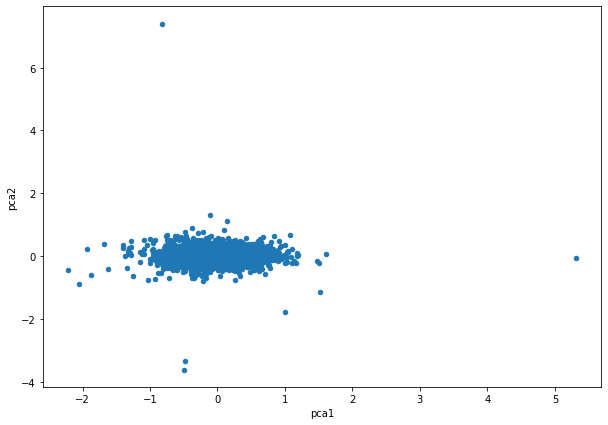

In [78]:
pca = PCA(n_components=2)

pca_df = pd.DataFrame(pca.fit_transform(feats_corr), columns=['pca1', 'pca2'], index=feats_corr.index)

(
    pca_df
    .plot.scatter(x='pca1', y='pca2')
)

In [81]:
(
    pca_df
    [(pca_df.pca2 > 2) | (pca_df.pca1 > 2) | (pca_df.pca2 < -2)]
)

,pca1,pca2
85,-0.485180,-3.323241
890,5.306770,-0.048296
905,-0.491129,-3.609570
2800,-0.824812,7.404099


<AxesSubplot:xlabel='pca1', ylabel='pca2'>

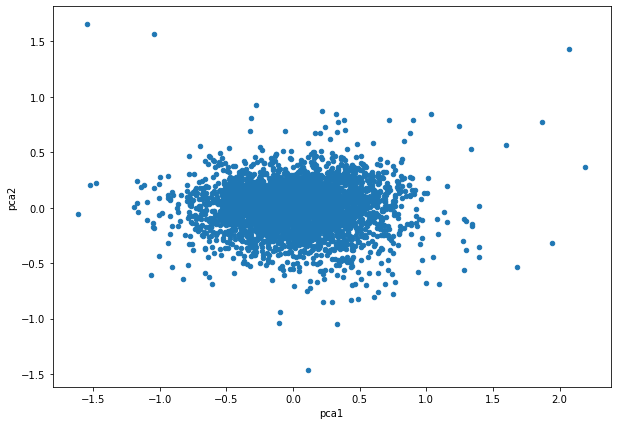

In [83]:
pca = PCA(n_components=2)

mask = ~feats_corr.index.isin([85, 890, 905, 2800])

pca_df = pd.DataFrame(pca.fit_transform(feats_corr[mask]), columns=['pca1', 'pca2'], index=feats_corr[mask].index)

(
    pca_df
    .plot.scatter(x='pca1', y='pca2')
)

In [97]:
gauss = GaussianMixture(n_components=1, covariance_type="full")
gauss.fit(feats_corr)

GaussianMixture()

In [104]:
feats_corr['likelyhood'] = gauss.score_samples(feats_corr)

<AxesSubplot:>

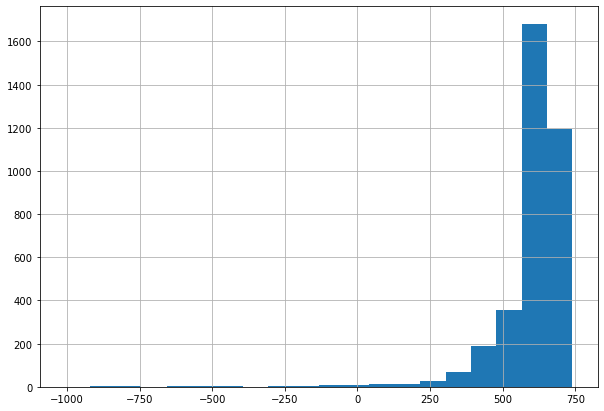

In [106]:
(
    feats_corr
    .likelyhood
    .hist(bins=20)
)

# Feature Selection

In [166]:
corr = (
        df
        [['target'] + [f'f_{i}' for i in range(300)]]
        .corr()
        ['target']
    )
corr

target    1.000000
f_0       0.009623
f_1      -0.015878
f_2       0.024120
f_3      -0.034535
            ...   
f_295    -0.022055
f_296    -0.005450
f_297    -0.042063
f_298    -0.014584
f_299    -0.004442
Name: target, Length: 301, dtype: float64

In [169]:
(
    corr.sort_values()[:-1]
)

f_231   -0.062049
f_250   -0.055839
f_265   -0.047300
f_280   -0.046870
f_197   -0.046128
f_65    -0.045656
f_25    -0.044642
f_155   -0.044370
f_71    -0.043966
f_15    -0.043521
f_212   -0.042891
f_179   -0.042872
f_237   -0.042688
f_297   -0.042063
f_190   -0.041945
f_286   -0.040812
f_137   -0.040361
f_165   -0.040247
f_255   -0.040118
f_172   -0.039994
f_58    -0.039941
f_118   -0.039915
f_168   -0.039733
f_243   -0.039676
f_185   -0.039301
f_92    -0.039281
f_247   -0.039170
f_232   -0.038951
f_100   -0.038693
f_106   -0.038518
f_187   -0.038274
f_21    -0.038227
f_135   -0.038188
f_42    -0.037947
f_257   -0.037909
f_41    -0.037449
f_246   -0.036947
f_79    -0.036453
f_146   -0.036381
f_216   -0.036287
f_80    -0.036279
f_214   -0.036067
f_83    -0.036055
f_273   -0.035910
f_52    -0.035522
f_3     -0.034535
f_31    -0.034377
f_207   -0.034340
f_268   -0.034036
f_233   -0.033903
f_256   -0.033764
f_226   -0.033744
f_78    -0.033592
f_113   -0.033293
f_90    -0.032510
f_274   -0

# Train Test

In [107]:
df_train = df[df.time_id <= 969]
df_test = df[df.time_id > 969]

In [118]:
X = df_train.drop(['row_id', 'target'], axis=1)
y = df_train['target']

In [119]:
X['investment_id_enc'] = X.investment_id.map(feats_corr['likelyhood']).fillna(feats_corr['likelyhood'].mean())

In [120]:
X_train, X_test = X[X.time_id <= 776].copy(), X[X.time_id > 776].copy()
y_train, y_test = y.loc[X_train.index].copy(), y.loc[X_test.index].copy()

In [121]:
X_train = X_train.drop(['time_id', 'investment_id'], axis=1)
X_test = X_test.drop(['time_id', 'investment_id'], axis=1)

In [122]:
X_train.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,investment_id_enc
0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,0.114807,-2.013672,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,655.082203
1,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,0.114807,-0.219238,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,661.776599
2,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,0.114807,-1.035156,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,642.823710
3,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,0.114807,-1.176758,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,606.349914
4,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,0.114807,-0.005859,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,651.737328


In [159]:
pipe = Pipeline([
    ('reg', LGBMRegressor(
        learning_rate=0.1, 
        n_estimators=500, 
        reg_alpha=1,
        #categorical_features=1,
        #cat_smooth=500
    ))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', LGBMRegressor(n_estimators=500, reg_alpha=1))])

In [160]:
y_hat = pipe.predict(X_train)

In [161]:
corr_score(y_train, y_hat)

0.358197439270491

In [162]:
y_hat = pipe.predict(X_test)

In [163]:
corr_score(y_test, y_hat)

0.11229863240883396

In [136]:
0.113

0.113

<AxesSubplot:>

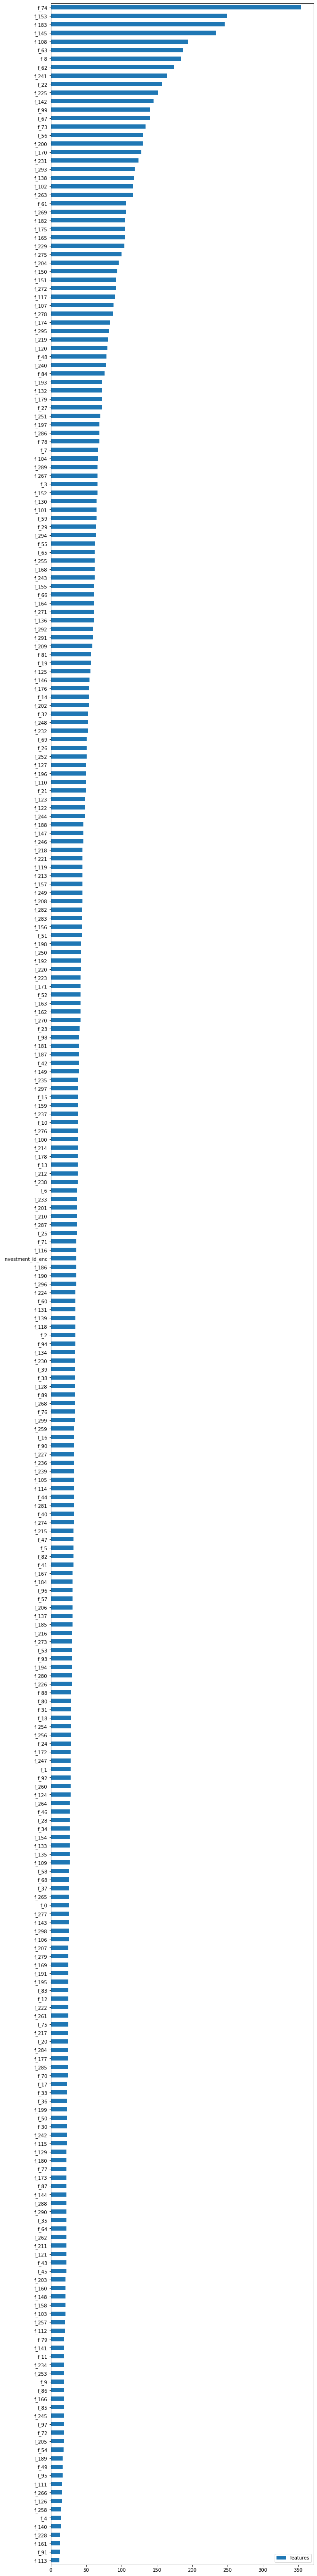

In [164]:
(
    pd.DataFrame(
        pipe['reg'].feature_importances_, 
        index=X_train.columns, 
        columns=['features']
    ).sort_values(by='features')
    .plot.barh(figsize=(10, 100))
)